In [6]:

import docker
docker_client = docker.from_env()
img = docker_client.images.pull(
            "ghcr.io/becksteinlab/streaming-md-docker:main-Common-CPU"
        )

container = docker_client.containers.run(
            img,
            f"/bin/sh -c 'cd /tmp && ./run.sh'",
            detach=True,
            volumes={"/nfs/homes3/ljwoods2/workspace/imd-workshop-2024/gromacs-demos/distances": {"bind": "/tmp", "mode": "rw"}},
            ports={"8889/tcp": 8889},
            name="sim",
            remove=True,
        )

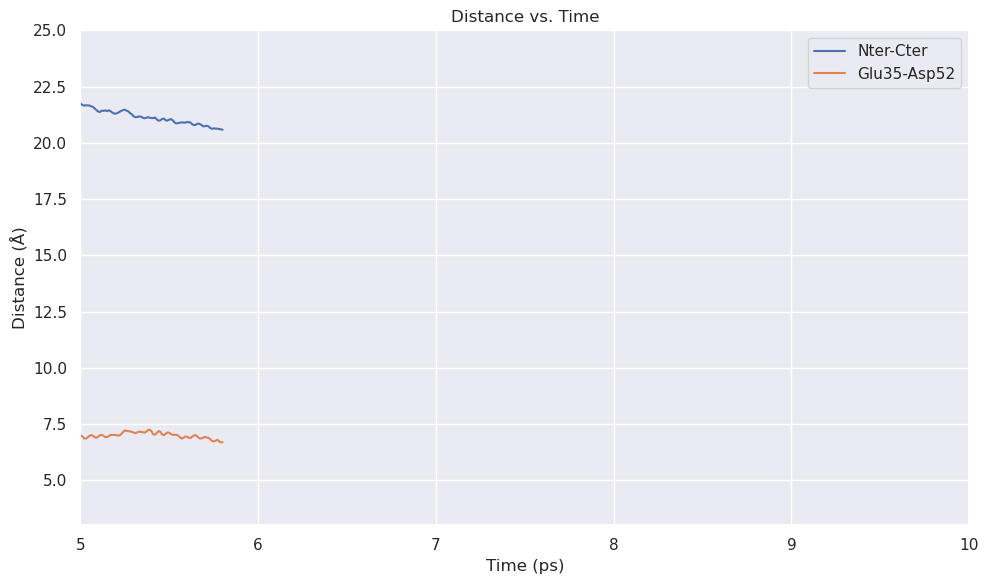

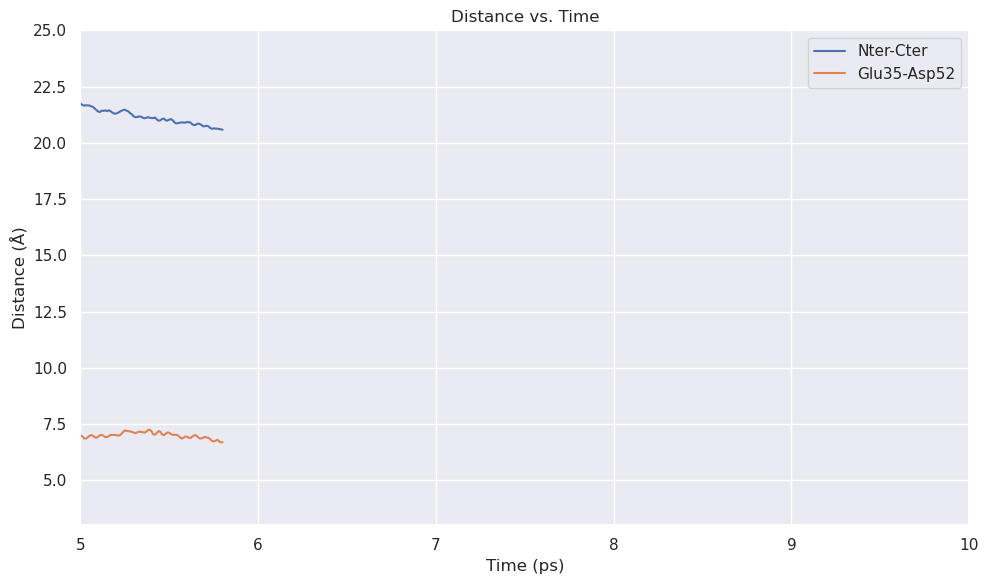

In [9]:
%matplotlib

from imdclient.IMDREADER import IMDReader
import numpy as np
import MDAnalysis as mda
import logging
import dynplot as dyn
import time as t
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


# %%
logger = logging.getLogger("imdclient.IMDClient")
file_handler = logging.FileHandler("imdreader.log")
formatter = logging.Formatter(
    "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)
logger.setLevel(logging.INFO)

timeWindow = 5.0
dtIMD = 0.010
nTimesPlot = (int)(timeWindow/dtIMD)

# %%
u = mda.Universe("mda.tpr", "imd://localhost:8889", buffer_size = 100*1024*1024)
Nter = u.select_atoms("resid 1 and name CA")
Cter = u.select_atoms("resid 129 and name CA")
GLU35 = u.select_atoms("resid 35 and name CD")
ASP52 = u.select_atoms("resid 52 and name CG")
time = np.zeros(nTimesPlot, dtype=np.float32)
dist1 = np.zeros(nTimesPlot, dtype=np.float32)
dist2 = np.zeros(nTimesPlot, dtype=np.float32)

plt.ion()  # Turn on interactive mode
fig, ax = plt.subplots(figsize=(10, 6))
p1, = ax.plot([], [], label='Nter-Cter')
p2, = ax.plot([], [], label='Glu35-Asp52')
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Distance (Å)')
ax.set_xlim(0, timeWindow)
ax.set_ylim(3, 25)
ax.set_title('Distance vs. Time')
ax.legend()
ax.grid(True)
plt.tight_layout()
display(fig)

min_idx = 0


i = 0
for ts in u.trajectory:
    idx = i % nTimesPlot
    time[idx] = ts.time
    dist1[idx] = np.linalg.norm(Nter.atoms[0].position - Cter.atoms[0].position)
    dist2[idx] = np.linalg.norm(GLU35.atoms[0].position - ASP52.atoms[0].position)

    if i % nTimesPlot == 0:
        min_idx = idx
        ax.set_xlim(time[idx], time[idx] + nTimesPlot*dtIMD)

    if i % timeWindow ==0:
        valid_indices = range(min_idx, idx + 1)
        p1.set_data(time[valid_indices], dist1[valid_indices])
        p2.set_data(time[valid_indices], dist2[valid_indices])
        
        clear_output(wait=True)  # Clear previous output
        display(fig)  # Redisplay the updated figure
    i += 1
# %%
logger.info(f"Parsed {i} frames")
plt.ioff()

